For my assignment, i will be analyzing stock for General Motors (GM). 
General Motors produces American-made automobiles such as Cadillac, Chevrolet and GMC. 

My Dataset is GM.csv, located at:
https://finance.yahoo.com/quote/GM/history?period1=1409979600&period2=1567746000&interval=1d&filter=history&frequency=1d


In [16]:
# import our dependencies
import math
import datetime
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import style
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [17]:
df = pd.read_csv('GM.csv')
df.set_index('Date', inplace=True)
print(df.head())

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2014-09-08  34.029999  34.150002  33.150002  33.240002  26.696589  22120600
2014-09-09  33.200001  33.299999  33.009998  33.070000  26.560049  11861000
2014-09-10  33.119999  33.340000  33.060001  33.290001  26.736742  10471000
2014-09-11  33.160000  33.700001  33.150002  33.610001  26.993746  10120400
2014-09-12  33.480000  33.599998  33.099998  33.270000  26.720680  11036200


In [18]:
# Adjusting the size and style of matplotlib
mpl.rc('figure', figsize=(8, 7))
mpl.__version__
style.use('ggplot')

Upon visualizing our DataFrame, we see that the closing prices have "skyrocketed" between November of 2017 and November 2018. The largest jump in price in any direction for this stock in the past 5 years. 
 
We also visualize our Moving Average for a 100-day window. I built graphs for a windows of 28-days, 56-days, and 100-days, and i chose to stick with the 100-day window because the moving average is less-sensitive to change and provided a smoother, less-volatile line. 

According to Investopedia.com: <b><i>"As a general guideline, if the price is above a moving average, the trend is up. If the price is below a moving average, the trend is down."</i></b> We can see that this is a fair metric to judge with, considering that any time the "adjusted close" line crosses the "moving average" line, for the most part, the adjusted close line will <b>stay</b> on that side of the moving average line for an amount of time reasonable to call the current trend 'up' or 'down'.

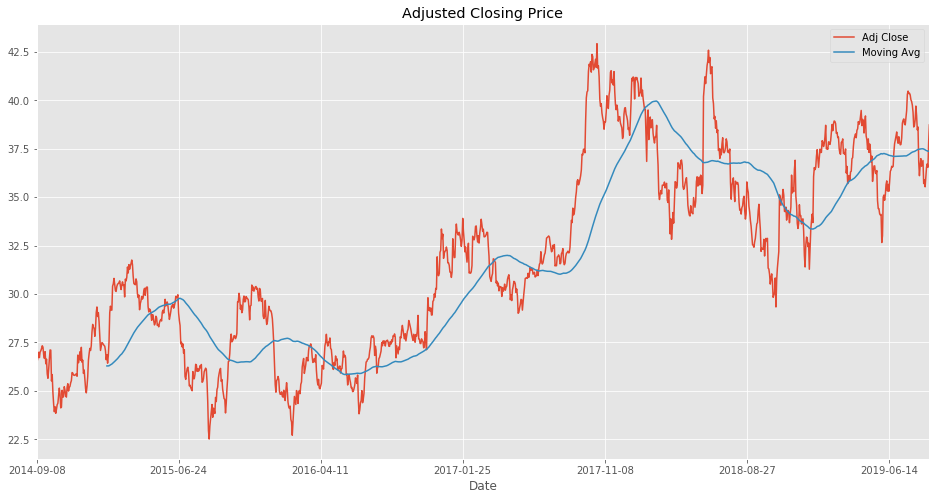

In [19]:
int_moving_avg_window = 100
df_adjcloseprice = df.copy()
df_adjcloseprice.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_adjcloseprice_movingavg = df_adjcloseprice
df_adjcloseprice_movingavg['Moving Avg'] = df_adjcloseprice_movingavg.rolling(window=int_moving_avg_window).mean()
df_adjcloseprice_movingavg.plot(label='GM', figsize=(16,8), title='Adjusted Closing Price', grid=True)
plt.legend()
plt.show()

In [21]:
# Engineering additional features, as suggested by the article within our homework readings
df_learn = df.loc[:,['Adj Close','Volume']]
df_learn['HiLo_Percent'] = (df['High'] - df['Low']) / df['Close'] * 100.0
df_learn['Percent_Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

df_learn.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df_learn)))
forecast_column = 'Adj Close'
df_learn['label'] = df_learn[forecast_column].shift(-forecast_out)

# Train-Test-Split
X = np.array(df_learn.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
y = np.array(df_learn['label'])
y = y[:-forecast_out]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)




As my regression methods, i am choosing to use:
1. Linear Regression
2. Quadratic Regression
3. Lasso Regression



	Linear Confidence: 0.8337535645013601


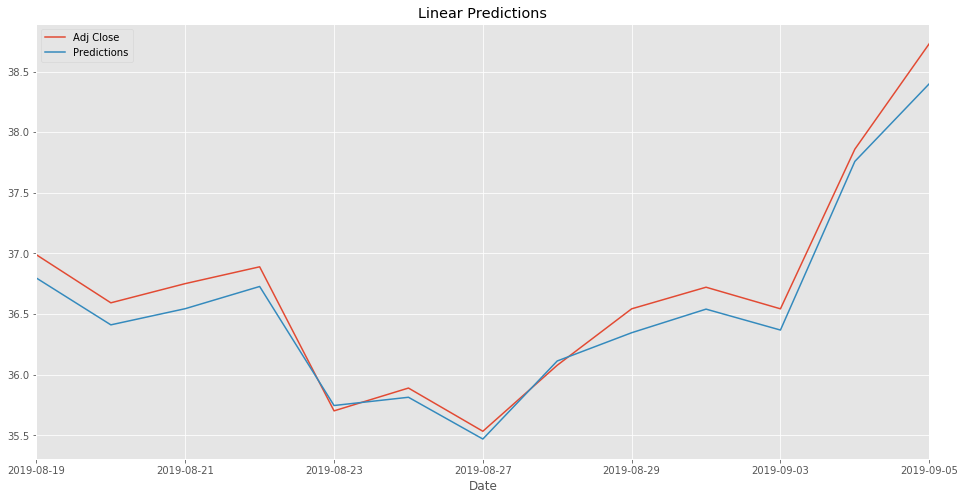

	Quadratic Confidence: 0.8424763247893294


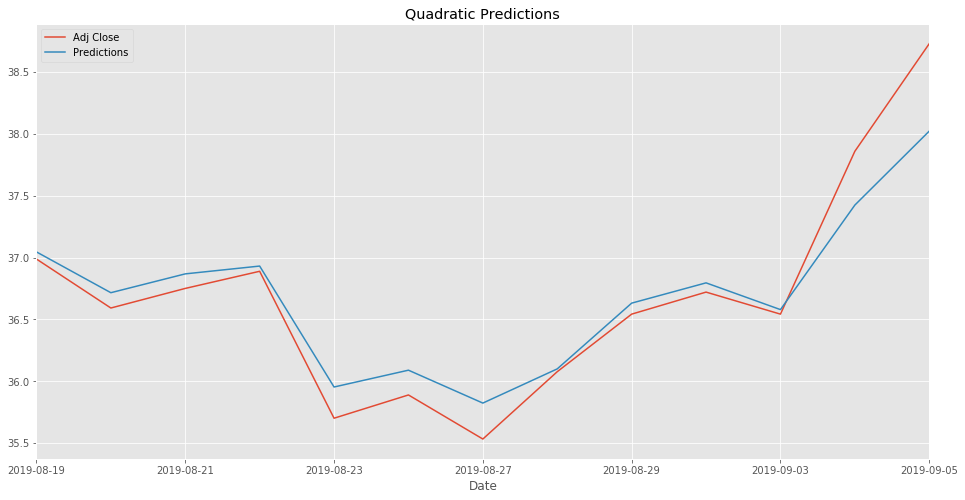

	Lasso Confidence: 0.8305018049966868


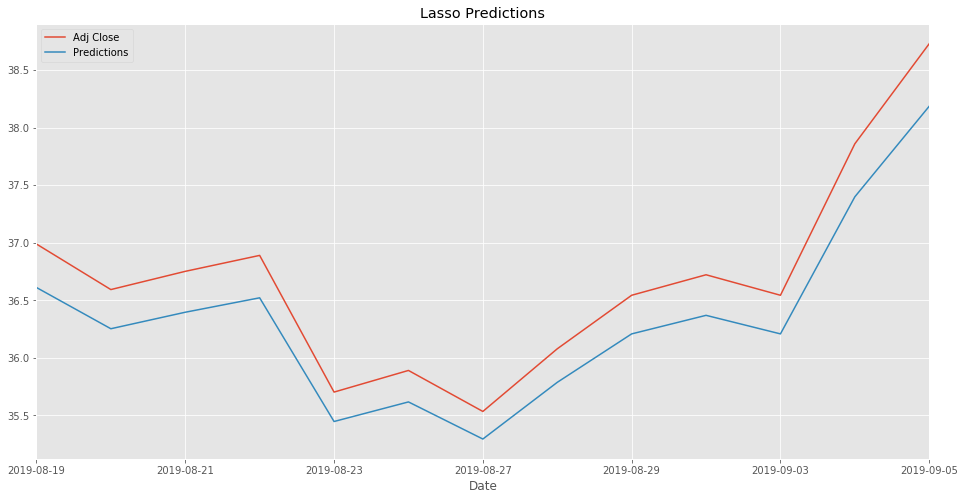


Most-Accurate Method
	0.8424763247893294
	Quadratic Confidence


In [22]:
# Training, Evaluating, and Visualizing our Models

df_predictions = df.copy()
df_predictions.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_predictions = df_predictions.iloc[-forecast_out:, :]

# Linear regression
classifier_linear = LinearRegression(n_jobs=-1)
classifier_linear.fit(X_train, y_train)
confidence_linear = classifier_linear.score(X_test, y_test)
print()

print()
print('\tLinear Confidence: ' + str(confidence_linear))
df_predictions_linear = df_predictions.copy()
df_predictions_linear['Predictions'] = classifier_linear.predict(X_lately)
df_predictions_linear.plot(label='GM', figsize=(16,8), title='Linear Predictions', grid=True)
plt.legend()
plt.show()

# Quadratic Regression
classifier_quadratic = make_pipeline(PolynomialFeatures(2), Ridge())
classifier_quadratic.fit(X_train, y_train)
confidence_quadratic = classifier_quadratic.score(X_test, y_test)
print('\tQuadratic Confidence: '+ str(confidence_quadratic))
df_predictions_quadratic = df_predictions.copy()
df_predictions_quadratic['Predictions'] = classifier_quadratic.predict(X_lately)
df_predictions_quadratic.plot(label='GM', figsize=(16,8), title='Quadratic Predictions', grid=True)
plt.legend()
plt.show()

# Lasso Regression
classifier_lasso = linear_model.Lasso(alpha=0.1)
classifier_lasso.fit(X_train, y_train)
confidence_lasso = classifier_lasso.score(X_test, y_test)
print('\tLasso Confidence: ' + str(confidence_lasso))
df_predictions_lasso = df_predictions.copy()
df_predictions_lasso['Predictions'] = classifier_lasso.predict(X_lately)
df_predictions_lasso.plot(label='GM', figsize=(16,8), title='Lasso Predictions', grid=True)
plt.legend()
plt.show()

list_results = [
    ['Linear Confidence', str(confidence_linear)],
    ['Quadratic Confidence', str(confidence_quadratic)],
    ['Lasso Confidence', str(confidence_lasso)]]
int_most_accurate_method = str(max([
    confidence_linear,
    confidence_quadratic,
    confidence_lasso]))
print()
print('Most-Accurate Method')
print('\t' + str(int_most_accurate_method))
print('\t' + [i for i in list_results if str(int_most_accurate_method) in i][0][0])